In [3]:
from collections import Counter
from collections import defaultdict
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import shapefile as shp
import pandas as pd
import pickle as pk
import numpy as np
import math
import sys

In [4]:
TEST_DAY="2013-08-19"
NumFlights=-1
NumColors=30
minutes=20

Airspacefile=open("Website/backend/OutputFolder/AirspaceTraffic.txt")
Airportfile=open("Website/backend/OutputFolder/AirportTraffic.txt")
OpToFrontend=open("Website/backend/OutputFolder/OutputToFrontend.txt")
MetricsGA=pd.read_csv("Website/backend/OutputFolder/AerialTimeGD.txt")

convexDict=pk.load(open("Notebooks/Outputs/ConvexDict.pkl","rb"))

AirspaceTrafficReal = []
RealMetrics={}
AirportTrafficReal = dict()
if(NumFlights==-1):
    AirspaceTrafficReal = pk.load(open(f"Dataset/{TEST_DAY}/{TEST_DAY}_SectorTimeDict_FullDay.pkl", "rb"))
    RealMetrics=pd.read_csv(f"Dataset/{TEST_DAY}/{TEST_DAY}-gd-aat_FullDay.csv")
    AirportTrafficReal = pk.load(open(f"Dataset/{TEST_DAY}/{TEST_DAY}_AirportTrafficDict_FullDay.pkl", "rb"))
else:
    AirspaceTrafficReal = pk.load(open(f"ShellScripts/RealMetrics/{TEST_DAY}_SectorTimeDict.pkl", "rb"))
    RealMetrics=pd.read_csv(f"ShellScripts/RealMetrics/{TEST_DAY}-gd-aat.csv")
    AirportTrafficReal = pk.load(open(f"ShellScripts/RealMetrics/{TEST_DAY}_AirportTrafficDict.pkl", "rb"))

dayFlights=pd.read_csv(f"Dataset/{TEST_DAY}/{TEST_DAY}_flights.csv")

The average difference between Dataset and GA model for Aerial Time is  6.525412824361998


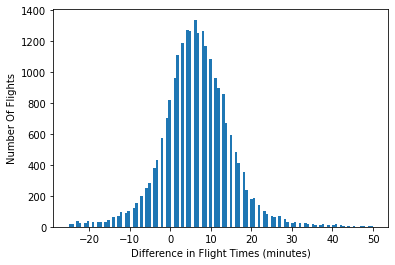

In [5]:
GA_AT=MetricsGA["Aerial Time"]
realAT=list(RealMetrics["Aerial Time"])

DiffAT=[]
for i in range(len(GA_AT)):
    DiffAT.append(realAT[i]-GA_AT[i])
DiffAT=list(filter(lambda x:-25 <=x <=50,DiffAT))
q25, q75 = np.percentile(DiffAT, [25, 75])
bin_width = 2 * (q75 - q25) * len(DiffAT) ** (-1/3)
binsAT = round((max(DiffAT) - min(DiffAT)) / bin_width)

plt.hist(DiffAT, range=(min(DiffAT),max(DiffAT)), bins=binsAT)
plt.xlabel('Difference in Flight Times (minutes)')
plt.ylabel('Number Of Flights')
plt.savefig(f"OutputImages/AerialTime{TEST_DAY}.png")


AvgDiff=sum(DiffAT)/len(DiffAT)
print("The average difference between Dataset and GA model for Aerial Time is ",AvgDiff)

Percentage of flights eliminated, 34.275071153524195%
Average Real Ground Delay is  18.261733426733745
Average GA Ground Delay is  12.0276380309495


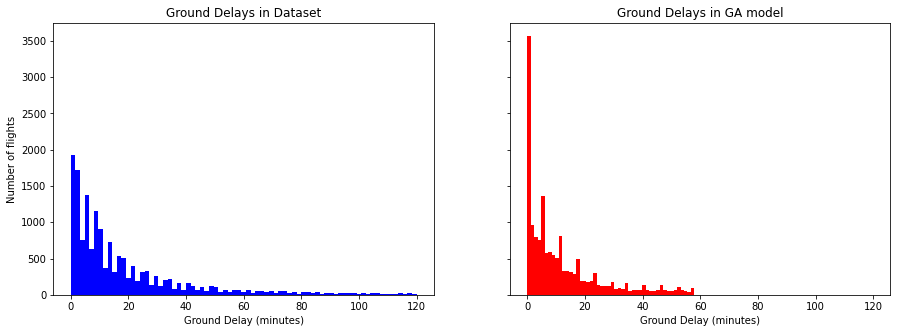

In [6]:
realGD=list(RealMetrics["ground_delay"])
NumFlights=len(realGD)
posIndex=[]
posReal_GD=[]
for i in range(len(realGD)):
    if(realGD[i]>=0 and realGD[i]<=120):
        posIndex.append(i)
        posReal_GD.append(realGD[i])
print(f"Percentage of flights eliminated, {((NumFlights-len(posReal_GD))/NumFlights)*100}%")

GA_GD=MetricsGA["Ground Holding"]
posGA_GD=[]
for i in posIndex:
    posGA_GD.append(GA_GD[i])

q25, q75 = np.percentile(posReal_GD, [25, 75])
bin_width = 2 * (q75 - q25) * len(posReal_GD) ** (-1/3)
binsRGD = round((max(posReal_GD) - min(posReal_GD)) / bin_width)

q25, q75 = np.percentile(posGA_GD, [25, 75])
bin_width = 2 * (q75 - q25) * len(posGA_GD) ** (-1/3)
if(bin_width==0):
    bin_width=1
binsGAGD = round((max(posGA_GD) - min(posGA_GD)) / bin_width)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5),sharey=True, sharex=True)
ax1.hist(posReal_GD, range=(min(posReal_GD),max(posReal_GD)), color="blue", bins=binsRGD,label="RealData")
ax1.set_title('Ground Delays in Dataset')
ax1.set_xlabel('Ground Delay (minutes)')
ax1.set_ylabel('Number of flights')
print("Average Real Ground Delay is ",sum(posReal_GD)/len(posReal_GD))

ax2.hist(posGA_GD, range=(min(posGA_GD),max(posGA_GD)), color="red" ,bins=binsGAGD)
ax2.set_title('Ground Delays in GA model')
ax2.set_xlabel('Ground Delay (minutes)')
print("Average GA Ground Delay is ",sum(posGA_GD)/len(posGA_GD))
plt.savefig(f"OutputImages/GroundDelay{TEST_DAY}.png")

Average Sector Density in Real Data 6.4216
Average Sector Density in GA Solution 5.2688
Percentage reduction in Sector Density across all sectors 17.951912296000998%


Average Sector Occupancy in Dataset 2.0582426161192315
Average Sector Occupancy in GA Solution 1.8781278368516672
Percentage reduction in Sector Occupancy across all sectors 8.750901271647294%


Sector Density Reduced in 55.60000000000001% of the sectors
Sector Density Reduced Or Equal in 77.28% of the sectors


Sector Occupancy Reduced in 58.32000000000001% of the sectors
Sector Occupancy Reduced Or Equal in 61.040000000000006% of the sectors


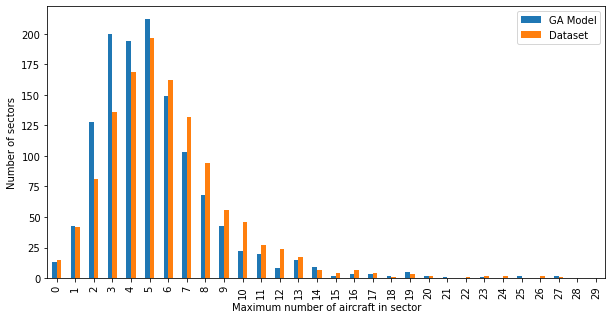

In [7]:
GATrafFactor=dict()
RealTrafFactor=dict()
SectorOccupancyReal=dict()
for sector in range(1250):
    NoZeroList=[]
    for i in AirspaceTrafficReal[sector]:
        if(i>0):
            NoZeroList.append(i)
    if(len(NoZeroList)==0):
        SectorOccupancyReal[sector]=0
    else:
        SectorOccupancyReal[sector]=sum(NoZeroList)/len(NoZeroList)
    RealTrafFactor[sector]=max(AirspaceTrafficReal[sector])

Airspacefile=open("Website/backend/OutputFolder/AirspaceTraffic.txt")
AirspaceMatrix=Airspacefile.read().splitlines()
sectorNumber=0
SectorOccupancyGA=dict()
for line in AirspaceMatrix:
    linelist=line.split(',')
    linelist = [ int(x) for x in linelist ]
    GATrafFactor[sectorNumber]=max(linelist)
    noZeroList=[]
    for i in linelist:
        if(i>0):
            noZeroList.append(i)
    if(len(noZeroList)==0):
        SectorOccupancyGA[sectorNumber]=0
    else:
        SectorOccupancyGA[sectorNumber]=sum(noZeroList)/len(noZeroList)
    sectorNumber+=1
    

GA_Counter=defaultdict(int)
Real_Counter=defaultdict(int)
for key,value in GATrafFactor.items():
    GA_Counter[value]+=1
for key,value in RealTrafFactor.items():
    Real_Counter[value]+=1
data={"Maximum number of aircraft in sector":[i for i in range(30)],
    "GA Model":[GA_Counter[sector] for sector in range(30)],
    "Dataset":[Real_Counter[sector] for sector in range(30)]}
SectorDataFrame=pd.DataFrame(data)
SectorDataFrame.plot.bar(x='Maximum number of aircraft in sector',figsize=(10,5),ylabel = 'Number of sectors')
plt.savefig(f"OutputImages/AirspaceTraffic_{TEST_DAY}.png")

TrafAvgReal=sum(RealTrafFactor.values())/1250
TrafAvgGA=sum(GATrafFactor.values())/1250
print(f"Average Sector Density in Real Data {TrafAvgReal}")
print(f"Average Sector Density in GA Solution {TrafAvgGA}")
less=0
lessorEqual=0
for i in range(1250):
    if(GATrafFactor[i]<RealTrafFactor[i]):
        less+=1
    if(GATrafFactor[i]<=RealTrafFactor[i]):
        lessorEqual+=1
lessOcc=0
lessorEqualOcc=0
for i in range(1250):
    if(SectorOccupancyGA[i]<SectorOccupancyReal[i]):
        lessOcc+=1
    if(SectorOccupancyGA[i]<=SectorOccupancyReal[i]):
        lessorEqualOcc+=1
print(f"Percentage reduction in Sector Density across all sectors {((TrafAvgReal-TrafAvgGA)/TrafAvgReal)*100}%")

A=sum(SectorOccupancyReal.values())/1250
B=sum(SectorOccupancyGA.values())/1250
print(f"\n\nAverage Sector Occupancy in Dataset {A}")
print(f"Average Sector Occupancy in GA Solution {B}")
print(f"Percentage reduction in Sector Occupancy across all sectors {((A-B)/A)*100}%")

print(f"\n\nSector Density Reduced in {(less/1250)*100}% of the sectors")
print(f"Sector Density Reduced Or Equal in {(lessorEqual/1250)*100}% of the sectors")
print(f"\n\nSector Occupancy Reduced in {(lessOcc/1250)*100}% of the sectors")
print(f"Sector Occupancy Reduced Or Equal in {(lessorEqualOcc/1250)*100}% of the sectors")

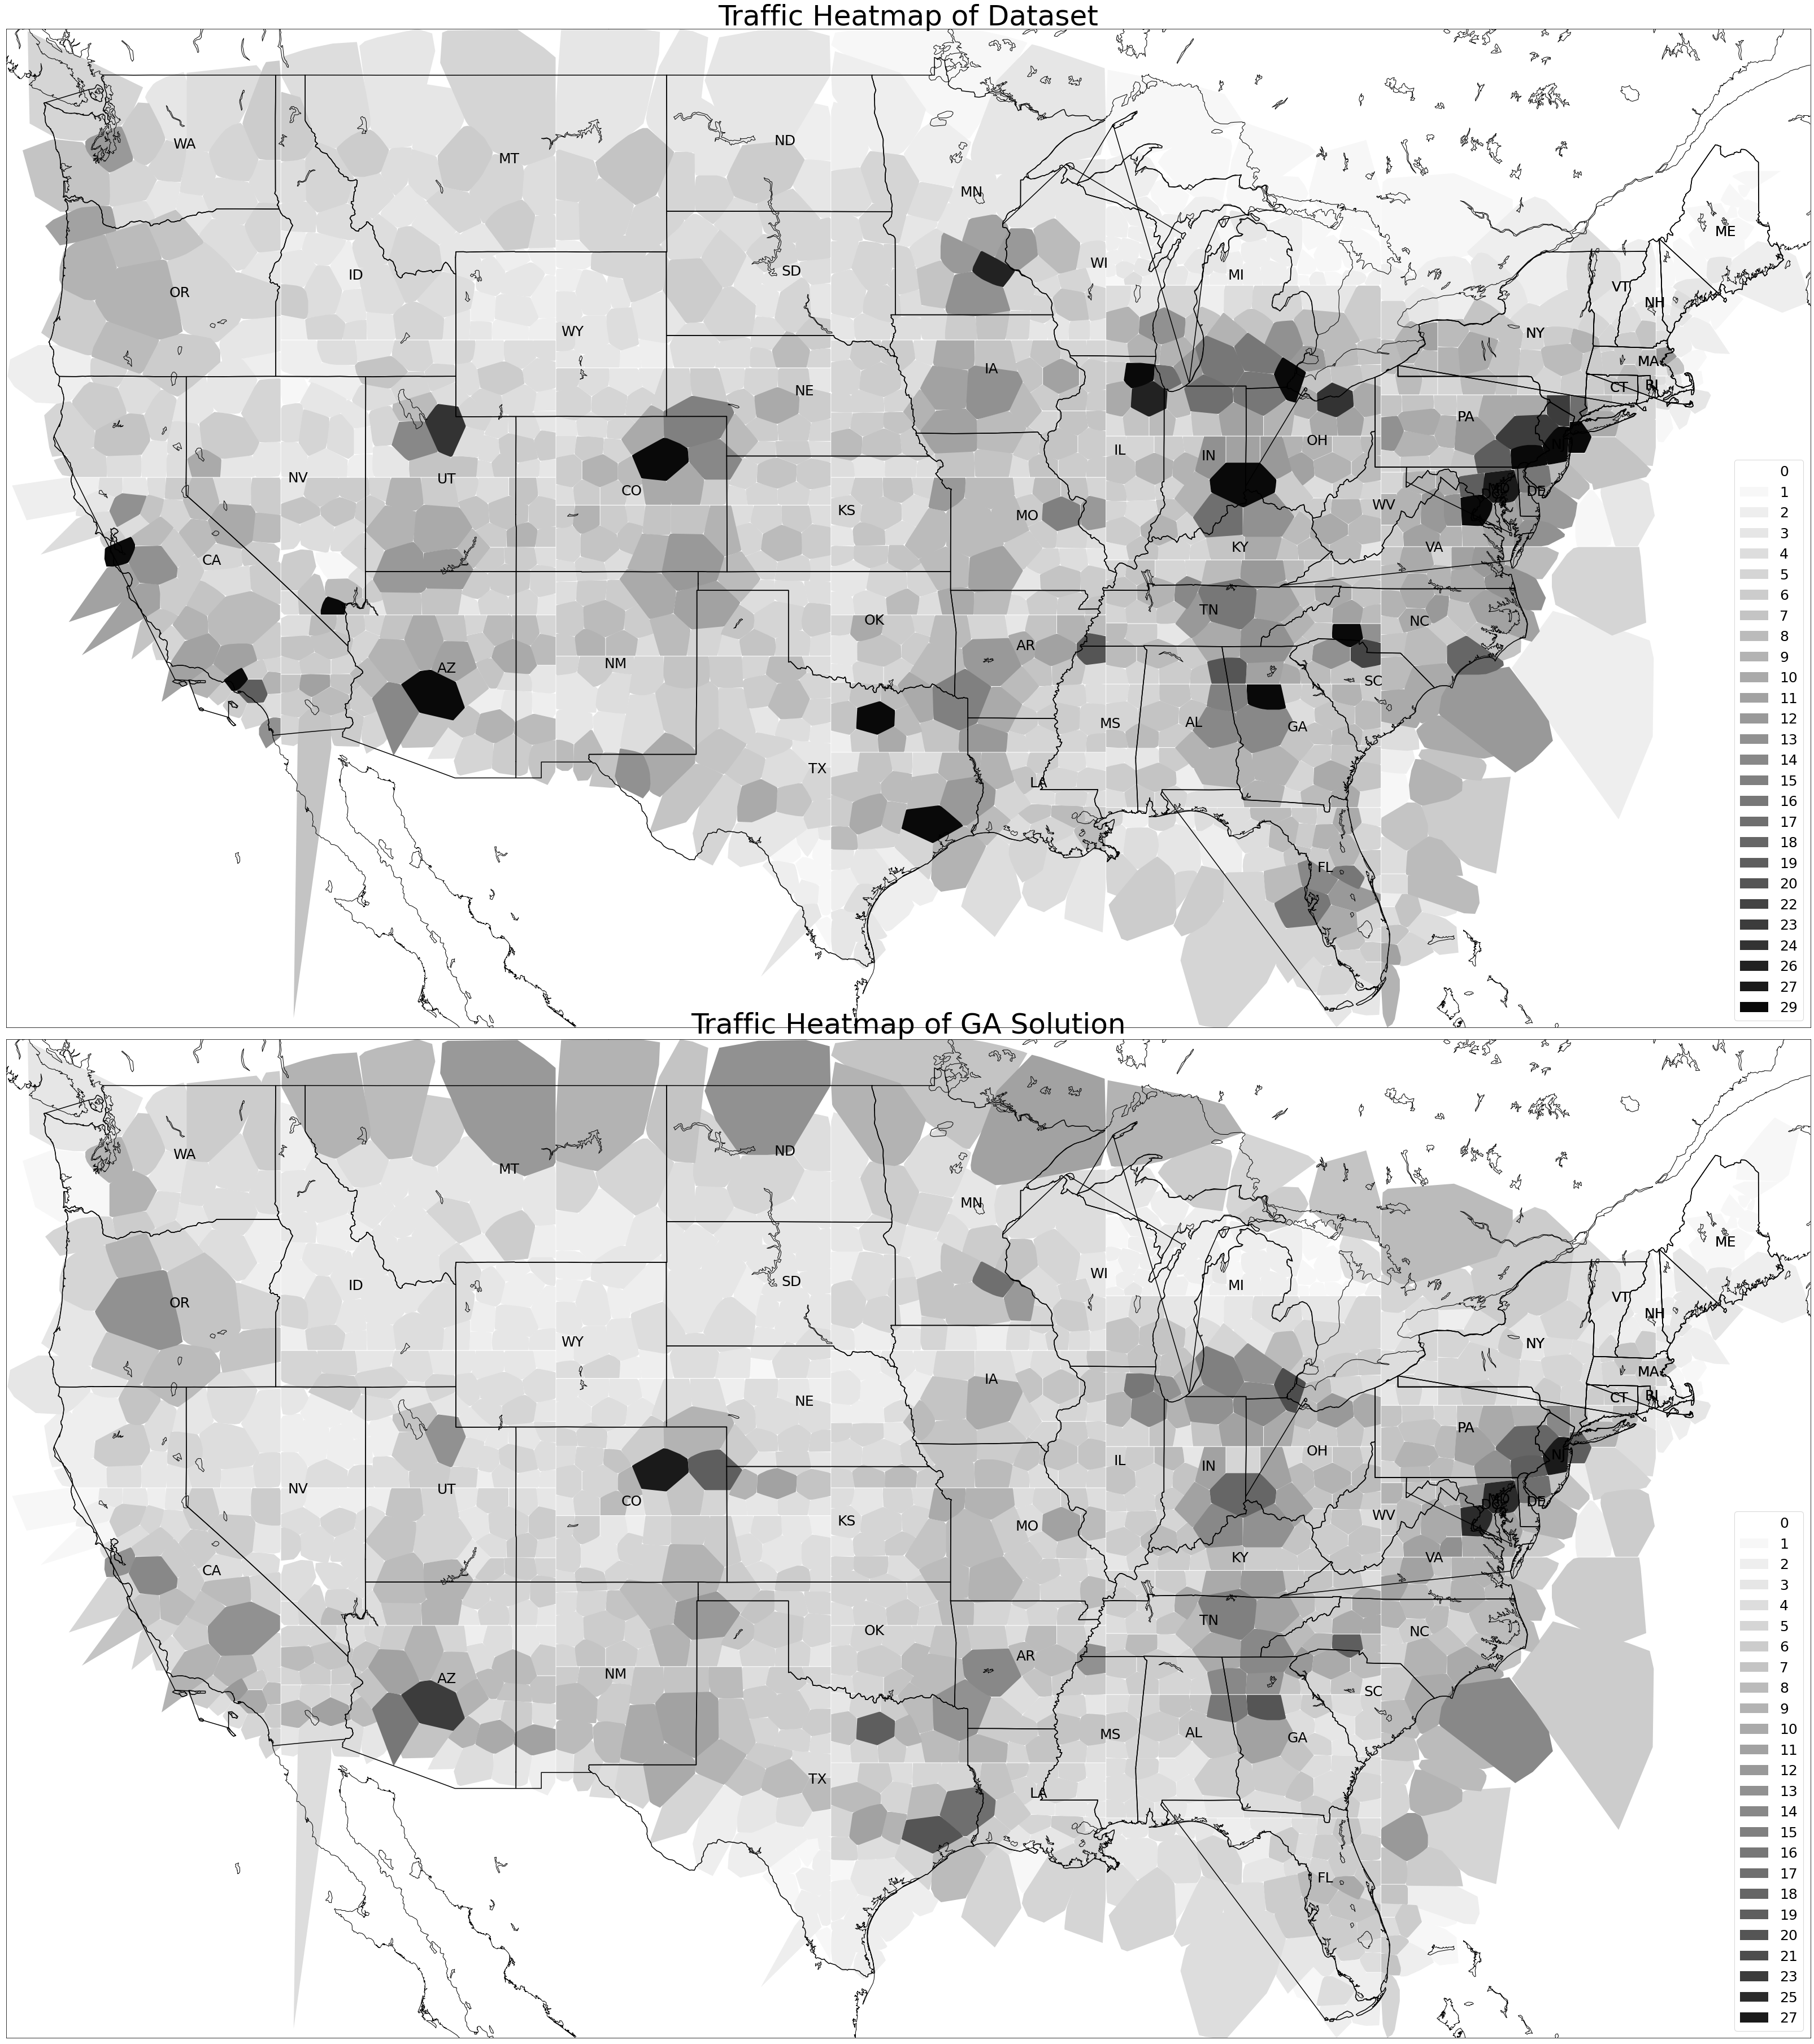

In [31]:
def getColours(K):
    d=dict()
    r,g,b=255,255,255
    cut=255/K
    for i in range(K):
        d[i]=[r/255,g/255,b/255]
        r-=cut
        g-=cut
        b-=cut
    return d
m=pk.load(open("Notebooks/Outputs/M_ConversionMetric.pkl",'rb'))
centers=pd.read_csv("Notebooks/Outputs/StateCentres.csv")
sf = shp.Reader('Notebooks/Outputs/StateShapes/usa-states-census-2014.shp')
dpi=10

fig,axs = plt.subplots(2,figsize=(50,50),sharex=True, sharey=True,facecolor='white')

fig.tight_layout()


for idd in range(0,len(sf.records())):
    shape_ex = sf.shape(idd)
    x_lon = np.zeros((len(shape_ex.points),1))
    y_lat = np.zeros((len(shape_ex.points),1))
    for ip in range(len(shape_ex.points)):
        x_lon[ip] = shape_ex.points[ip][0]
        y_lat[ip] = shape_ex.points[ip][1]
    xm_lon, ym_lat = m(x_lon, y_lat)
    axs[0].plot(xm_lon, ym_lat, c='black',linewidth=1.5)
    axs[1].plot(xm_lon, ym_lat, c='black',linewidth=1.5)
    Name=sf.records()[idd][5]
    StateCenter=centers[centers["State"]==Name]
    lat=StateCenter["CenterLat"]
    lon=StateCenter["CenterLon"]
    x,y=m(lon,lat)
    axs[0].text(x,y,f"{sf.records()[idd][4]}",fontsize=25)
    axs[1].text(x,y,f"{sf.records()[idd][4]}",fontsize=25)
plt.sca(axs[0])
m.drawcoastlines(zorder=6)
plt.sca(axs[1])
m.drawcoastlines(zorder=6)



realData=RealTrafFactor
hue=sorted([(k,v) for k,v in realData.items()],key=lambda x:x[1])
colors=getColours(NumColors)
seen=[False]*NumColors
for sector,k in hue:
    if k >= NumColors:
        k=NumColors-1
    x,y=zip(*convexDict[sector])
    colour=colors[k]
    if(not seen[k]):
        axs[0].fill(x,y,facecolor=colour,label=k)
        seen[k]=True
    else:
        axs[0].fill(x,y,facecolor=colour,label=f"_{k}")
axs[0].legend(prop={'size': 25})
axs[0].set_title("Traffic Heatmap of Dataset",fontsize = 50)



gaDict=GATrafFactor
hue=sorted([(k,v) for k,v in gaDict.items()],key=lambda x:x[1])
seen=[False]*NumColors
for sector,k in hue:
    if k >= NumColors:
        k=NumColors-1
    x,y=zip(*convexDict[sector])
    colour=colors[k]
    if(not seen[k]):
        axs[1].fill(x,y,facecolor=colour,label=k)
        seen[k]=True
    else:
        axs[1].fill(x,y,facecolor=colour,label=f"_{k}")
axs[1].legend(prop={'size': 25})
axs[1].set_title("Traffic Heatmap of GA Solution",fontsize = 50)
plt.savefig(f"{TEST_DAY}_Heatmap.png",bbox_inches="tight")